# MOLEARN ANALYSIS

Let's start by loading packages

In [1]:
import sys, os, glob
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import modeller
from modeller import *
from modeller.scripts import complete_pdb

import biobox as bb

sys.path.insert(0, "C:\\Users\\xdzl45\\workspace\\molearn") #edit as required for your computer
from molearn import load_data, Auto_potential, Autoencoder, ResidualBlock

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### 1. Load neural network and training set

Define neural network file (variable `networkfile`) and training set (variable `datasetfile`)

In [2]:
networkfile = "C:\\temp\\Dropbox\\Durham\\data\\neural_net\\conv1d-physics-path_B.pth"
datasetfile = "C:\\Users\\xdzl45\\workspace\\molearn\\test\\MurD_test.pdb"

Load dataset

In [3]:
dataset, meanval, stdval, atom_names, mol, test0, test1 = load_data(datasetfile, atoms = ["CA", "C", "N", "CB", "O"], device=device)

Getting rmsd from file:  rmsd_matrix.npy
Conformations: (also saved to dataset_conformations.npy)
[]


Load the trained network

In [4]:
checkpoint = torch.load(networkfile, map_location=device)
network = Autoencoder(m=2.0, latent_z=2, r=2).to(device)
network.load_state_dict(checkpoint['model_state_dict'])

for modulelist in [network.encoder, network.decoder]:
    for layer in modulelist:
        if type(layer)==torch.nn.BatchNorm1d:
            layer.momentum=1.0
        elif type(layer)==ResidualBlock:
            for rlayer in layer.conv_block:
                if type(rlayer)==torch.nn.BatchNorm1d:
                    rlayer.momentum=1.0
                    
with torch.no_grad():
    network.decode(network.encode(dataset.float()))

network.eval()

Autoencoder(
  (encoder): ModuleList(
    (0): Conv1d(3, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(64, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
      )
    )
    (7): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=

### 2. Projection into latent space

Get projection in latent space of whole training set 

In [5]:
with torch.no_grad():
    z = network.encode(dataset.float())

Decode latent space projection of training set 

In [6]:
with torch.no_grad():  
    decoded = network.decode(z)[:,:,:dataset.shape[2]]

RMSD of input vs autoencoded

In [7]:
rmsd_all = []
for i in range(decoded.shape[0]):

    crd_ref = dataset[i].permute(1,0).unsqueeze(0).data.cpu().numpy()
    crd_mdl = decoded[i].permute(1,0).unsqueeze(0).data.cpu().numpy()[:, :dataset.shape[2]] #clip the padding of models

    # use Molecule Biobox class to calculate RMSD 
    mol.coordinates = deepcopy(crd_ref)
    mol.set_current(0)
    mol.add_xyz(crd_mdl[0])
    mol.coordinates *= stdval
    mol.coordinates += meanval
    rmsd_all.append(mol.rmsd(0, 1))

Text(0, 0.5, 'count / #')

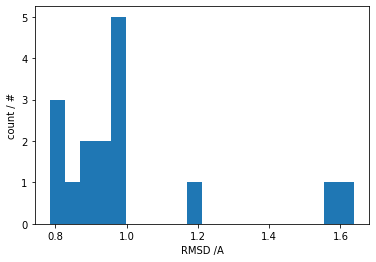

In [198]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(rmsd_all, bins= 20)
ax.set_xlabel("RMSD /A")
ax.set_ylabel("count / #")

### 3. Iterative Autoencoding

The following function repeats and encode-decode cycle on a neural network, starting from a given target structure if a `Molecule` object is provided as parameter, saves and returns coordinates in a `Molecule` structure

In [8]:
def loop_autoencoder(network, target, M=-1, iterations=5, verbose=False):
    
    inputsize = target.shape[1] #get number of atoms in target structure

    if not isinstance(M, int):
        #M: place where to store coordinates of generated models (preloading original structure)
        crds_ref = target.permute(1,0).unsqueeze(0).data.cpu().numpy()
        M.coordinates = crds_ref
        M.set_current(0)
    else:
        print("skipping molecule loading...")

    z_val = [] # storage space for latent space projections through iterations

    # encode, decode, re-encode, re-decode, re-re-encode, ... (n times)
    for i in range(iterations):

        # encode and decode (overwrite "target" for next iteration)
        with torch.no_grad():
            z = network.encode(target.unsqueeze(0).float())
            target = network.decode(z)[0,:,:dataset.shape[2]]

        # store latent space projection projection
        pos = z.data.cpu().numpy().flatten()
        z_val.append(pos)
        
        if verbose:
            print(i, pos)

        if not isinstance(M, int):
            # store generated structure upon request
            crds_ref = target.permute(1,0).unsqueeze(0).data.cpu().numpy()[0, :inputsize]
            M.add_xyz(crds_ref)

    if not isinstance(M, int):
        return M, z_val
    else:
        return z_val

Set a structure as starting point

In [9]:
idx = 5 #index of structure
target = deepcopy(dataset[idx])

Loop network from that starting point (then rescaling all molecules coordinates)

In [10]:
mol2, z_val = loop_autoencoder(network, target, mol, iterations=200)
mol2.coordinates *= stdval
mol2.coordinates += meanval

Iterate over all examples in training set and get paths followed by all

In [11]:
iterations = 200
allz = []
d = deepcopy(dataset).float()
for i in range(iterations):
    with torch.no_grad():
        z = network.encode(d)
        d = network.decode(z)[:,:,:dataset.shape[2]]
        allz.append(z.numpy())
        
allz = np.array(allz)
allz = allz.reshape(iterations, dataset.shape[0], 2).transpose(1, 0, 2)

0 torch.Size([16, 2, 1])
1 torch.Size([16, 2, 1])
2 torch.Size([16, 2, 1])
3 torch.Size([16, 2, 1])
4 torch.Size([16, 2, 1])
5 torch.Size([16, 2, 1])
6 torch.Size([16, 2, 1])
7 torch.Size([16, 2, 1])
8 torch.Size([16, 2, 1])
9 torch.Size([16, 2, 1])
10 torch.Size([16, 2, 1])
11 torch.Size([16, 2, 1])
12 torch.Size([16, 2, 1])
13 torch.Size([16, 2, 1])
14 torch.Size([16, 2, 1])
15 torch.Size([16, 2, 1])
16 torch.Size([16, 2, 1])
17 torch.Size([16, 2, 1])
18 torch.Size([16, 2, 1])
19 torch.Size([16, 2, 1])
20 torch.Size([16, 2, 1])
21 torch.Size([16, 2, 1])
22 torch.Size([16, 2, 1])
23 torch.Size([16, 2, 1])
24 torch.Size([16, 2, 1])
25 torch.Size([16, 2, 1])
26 torch.Size([16, 2, 1])
27 torch.Size([16, 2, 1])
28 torch.Size([16, 2, 1])
29 torch.Size([16, 2, 1])
30 torch.Size([16, 2, 1])
31 torch.Size([16, 2, 1])
32 torch.Size([16, 2, 1])
33 torch.Size([16, 2, 1])
34 torch.Size([16, 2, 1])
35 torch.Size([16, 2, 1])
36 torch.Size([16, 2, 1])
37 torch.Size([16, 2, 1])
38 torch.Size([16, 2, 

Analysis of autoencoding iteration of single structure

In [12]:
z_val = np.array(z_val) #evolution of position in 2D latent space 
r_mat = mol2.rmsd_distance_matrix() # RMSD all-vs-all
r_dist = np.diagonal(r_mat, offset=1) #RMSD between consecutive iterations
z_dist = np.sqrt(np.sum((z_val[:-1]-z_val[1:])**2,axis=1)) # Euclidean distance in latent space of consecutive iterations
mol2.write_pdb("test.pdb") # evolution of molecular models through iterations

print("Step: ", len(z_dist) ,". Distance: ", z_dist[-1], ". RMSD: ", r_dist[-1])

Step:  199 . Distance:  1.1926748e-07 . RMSD:  2.600044153001735e-05


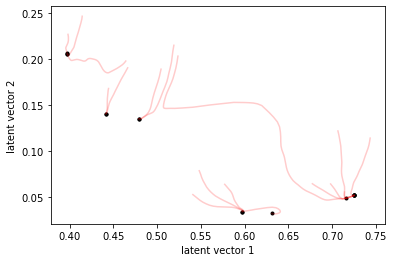

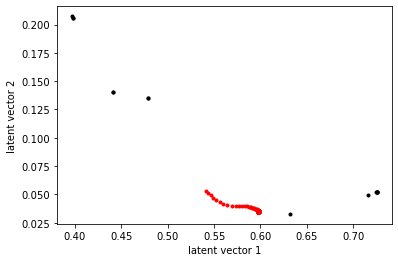

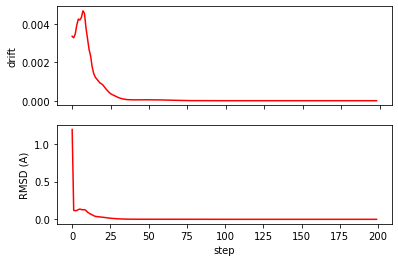

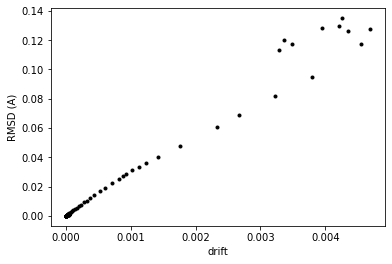

In [13]:
lenclosed = -1

z_training = z.data.cpu().numpy()[:,:,0] #save for later plotting

### plot position in latent space ###

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#if simulation is broken in two parts, plot them in different colours
if lenclosed != -1:
    plt.plot(z_training[:lenclosed, 0], z_training[:lenclosed, 1], "k.")
    plt.plot(z_training[lenclosed:, 0], z_training[lenclosed:, 1], "b.")
else:
    plt.plot(z_training[:, 0], z_training[:, 1], "k.")

#plot paths followed by all iterations (if True)
if True:
    for z in allz:
        plt.plot(z[:, 0], z[:, 1], "r-", alpha=0.2)


ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")


### plot position in latent space before and after looping ###

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

if lenclosed != -1:
    plt.plot(allz[:lenclosed, -1, 0], allz[:lenclosed, -1, 1], "k.")
    plt.plot(allz[lenclosed:, -1, 0], allz[lenclosed:, -1, 1], "b.")
else:
    plt.plot(allz[:, -1, 0], allz[:, -1, 1], "k.")

ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

#plot paths of structure of interest (if True)
if True:
    plt.plot(z_val[:, 0], z_val[:, 1], "r.", alpha=1, linewidth=1.0)
        
### plot evolution of single structure between consecutive itererations ###

fig = plt.figure()

# distances in latent space
ax = fig.add_subplot(2,1,1)
ax.plot(np.arange(len(z_dist)), z_dist, "r-", fillstyle="none")
ax.set_xticklabels([])
ax.set_ylabel("drift")

# RMSD between original and autoencoded
ax = fig.add_subplot(2,1,2)
ax.plot(np.arange(len(r_dist)), r_dist, "r-", fillstyle="none")
ax.set_xlabel("step")
ax.set_ylabel("RMSD (A)")


fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.plot(z_dist, r_dist[1:], "k.")
ax.set_xlabel("drift")
ax.set_ylabel("RMSD (A)")

plt.show()

### 4. latent space drift vs reconstruction RMSD

Text(0, 0.5, 'RMSD (A)')

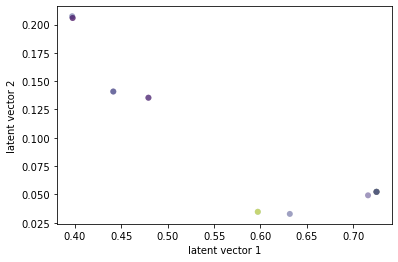

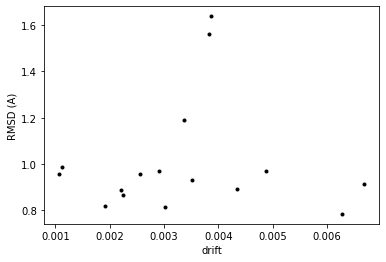

In [14]:
#projection colored by RMSD
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(z_training[:, 0], z_training[:, 1], c=rmsd_all, alpha=0.5, edgecolor="none")
ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

#drift vs RMSD
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
dists = np.sqrt((allz[:, 0, 0]-allz[:, 1, 0])**2 + (allz[:, 0, 1]-allz[:, 1, 1])**2)

plt.plot(dists, rmsd_all, "k.")

ax.set_xlabel("drift")
ax.set_ylabel("RMSD (A)")

### 5. Calculate DOPE scores

Define a function calculating the DOPE score via Modeller

In [89]:
def dope_score(file1):
    #outfile = file1+".log"
    #env = environ()
    env = Environ()
    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')
    mdl = complete_pdb(env, file1)
    atmsel = Selection(mdl.chains[0])
    #atmsel = selection(mdl.chains[0])
    score = atmsel.assess_dope()
    return score

Calculate DOPE score of all conformations in the training set

In [90]:
mymol = bb.Molecule()
mymol.import_pdb(datasetfile)

testH = mymol.data["resname"].values
testH[testH == "HIE"] = "HIS"
testH[testH == "HID"] = "HIS"
mymol.data["resname"] = testH
_, idxs = mymol.atomselect("*", "*", ["CA", "C", "N", "CB", "O"], get_index=True)

dptrain = []
for i in range(len(mymol.coordinates)):
    print(i)
    mymol.write_pdb("tmp.pdb", index=idxs, conformations=[i])
    s = dope_score("tmp.pdb")
    dptrain.append(s)

0

                         MODELLER 10.2, 2021/11/15, r12267

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2021 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, WinNT 10.0 build 19043, DM-PHY-122, SMP, unknown
Date and time of

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641261
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   633847
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   636905
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

Calculate DOPE score of all interpolation

In [91]:
mymol = bb.Molecule()
mymol.import_pdb("test.pdb")

testH = mymol.data["resname"].values
testH[testH == "HIE"] = "HIS"
testH[testH == "HID"] = "HIS"
mymol.data["resname"] = testH

dp = []
for i in range(len(mymol.coordinates)):
    print(i)
    mymol.write_pdb("tmp.pdb", conformations=[i])
    s = dope_score("tmp.pdb")
    dp.append(s)

0
read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   641261
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH    

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   632493
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631674
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631075
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630832
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   630960
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631076
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631105
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631118
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631094
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631074
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631055
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631038
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631016
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631024
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631026
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631024
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631021
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631013
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631014
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631011
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631011
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631011
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631011
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631011
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631008
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631012
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

read_to_681_> topology.submodel read from topology file:        3
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  GLY:OXT  GLY
preppdf_453W> No fixed restraints selected; there may be some dynamic ones.
preppdf_454W> Restraints file was probably not read; use restraints.append().


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in MODEL                   :      437
Number of all, selected real atoms                :     3286    3286
Number of all, selected pseudo atoms              :        0       0
Number of all static, selected restraints         :        0       0
COVALENT_CYS                                      :        F
NONBONDED_SEL_ATOMS                               :        1
Number of non-bonded pairs (excluding 1-2,1-3,1-4):   631005
Dynamic pairs routine                             : 1, NATM x NATM double loop
Atomic shift for contacts update (UPDATE_DYNAMIC) :    0.390
LENNARD_JONES_SWITCH      

interp. DOPE: -34421.75 pm 848.82 [-37728.38, -33950.66]
DOPE at transition state: -35251.04
training DOPE: -37047.37 pm 897.01 [-38356.05, -35425.87]


Text(0, 0.5, 'DOPE score')

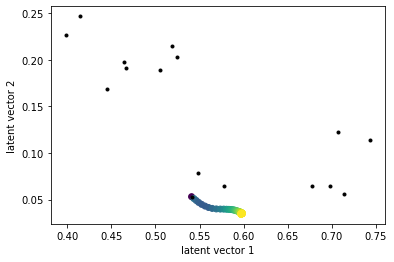

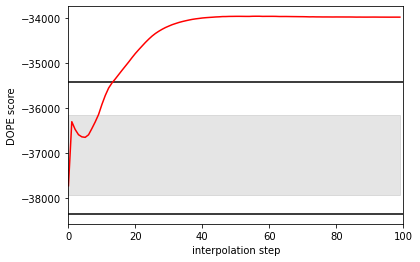

In [92]:
# DOPE of interpolation
halt = 100
dope = np.array(dp)
print("interp. DOPE: %6.2f pm %6.2f [%6.2f, %6.2f]"%(np.mean(dope[:halt]), np.std(dope[:halt]), np.min(dope[:halt]), np.max(dope[:halt])))
print("DOPE at transition state: %6.2f"%dope[15])

#DOPE of training set
dopetrain = np.array(dptrain)
print("training DOPE: %6.2f pm %6.2f [%6.2f, %6.2f]"%(np.mean(dopetrain), np.std(dopetrain), np.min(dopetrain), np.max(dopetrain)))

# color path followed as a function of DOPE score
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

if lenclosed != -1:
    plt.plot(allz[:lenclosed, 0, 0], allz[:lenclosed, 0, 1], "k.", alpha=0.5)
    plt.plot(allz[lenclosed:, 0, 0], allz[lenclosed:, 0, 1], "b.", alpha=0.5)
else:
    plt.plot(allz[:, 0, 0], allz[:, 0, 1], "k.")

ax.set_xlabel("latent vector 1")
ax.set_ylabel("latent vector 2")

plt.scatter(z_val[0:halt, 0], z_val[0:halt, 1], c=dope[0:halt], alpha=1, linewidth=1.0)
    
# DOPE score of interpolation compared to training set distribution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ymin = np.ones(halt)*(np.mean(dopetrain) - np.std(dopetrain))
ymax = np.ones(halt)*(np.mean(dopetrain) + np.std(dopetrain))
ax.hlines([np.min(dopetrain), np.max(dopetrain)], 0, halt, color="k")
ax.fill_between(np.arange(halt), ymin, ymax, color="k", alpha=0.1)
ax.plot(np.arange(halt), dope[0:halt], "r-")
ax.set_xlim([0, halt])
ax.set_xlabel("interpolation step")
ax.set_ylabel("DOPE score")

### 7. Evaluate re-encoding error (grid search)

In [15]:
bx = (np.max(z_training[:, 0]) - np.min(z_training[:, 0]))*0.1
by = (np.max(z_training[:, 1]) - np.min(z_training[:, 1]))*0.1
xvals = np.linspace(np.min(z_training[:, 0])-bx, np.max(z_training[:, 0])+bx, 50)
yvals = np.linspace(np.min(z_training[:, 1])-by, np.max(z_training[:, 1])+by, 50)
surf_z = np.zeros((len(xvals), len(yvals)))
surf_c = np.zeros((len(xvals), len(yvals)))

with torch.no_grad():
    
    for x, i in enumerate(xvals):
        for y, j in enumerate(yvals):
    
            z1 = torch.tensor([[[i,j]]]).float()
            s1 = network.decode(z1)[:,:,:dataset.shape[2]]
            
            z2 = network.encode(s1)
            s2 = network.decode(z2)[:,:,:dataset.shape[2]]
            
            surf_z[x,y] = np.sum((z2.numpy().flatten()-z1.numpy().flatten())**2) # Latent space L2 (sqrt later)
            surf_c[x,y] = np.sum((s2.numpy().flatten()-s1.numpy().flatten())**2) # Cartesian L2 (sqrt later)
            
surf_c = np.sqrt(surf_c)
surf_z = np.sqrt(surf_z)

Plot error surfaces

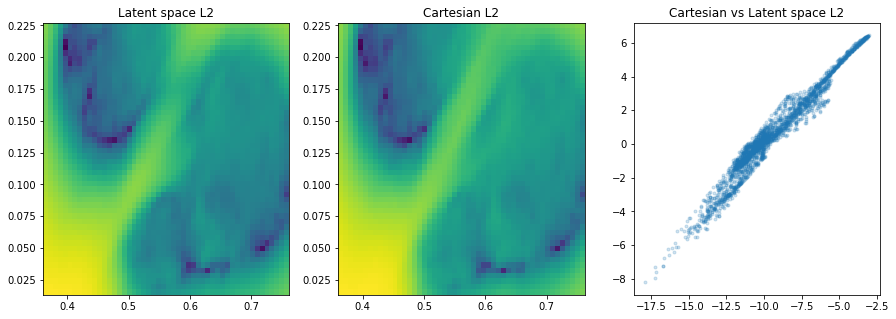

In [193]:
x, y = np.meshgrid(xvals, yvals)
sz = np.log(surf_z) # log for visualization purposes
sc = np.log(surf_c) # log for visualization purposes

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.set_title("Latent space L2")
ax.pcolormesh(x, y, sz.T)

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Cartesian L2")
ax.pcolormesh(x, y, sc.T)

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Cartesian vs Latent space L2")
ax.plot(sz.flatten(), sc.flatten(), ".", alpha=0.2)

# INTERACTIVE PLOT

In [201]:
from ipywidgets import HBox, VBox, Layout
from ipywidgets import widgets
import plotly.graph_objects as go
import MDAnalysis as mda
import nglview as nv
import warnings
warnings.filterwarnings("ignore")
import time

# tmp, creation of an MDAnalysis object containing all the information on the generated structure
mymol = mda.Universe('tmp.pdb')

def oversample(crd, pts=10):
    '''
    add extra equally spaced points between a list of points ("pts" per interval)
    ''' 
    
    steps = np.linspace(1./pts, 1, pts)
    pts = [crd[0,0]]
    for i in range(1, len(crd[0])):
        for j in steps:
            newpt = crd[0, i-1] + (crd[0, i]-crd[0, i-1])*j
            pts.append(newpt)
    
    return np.array([pts])

def generate(network, crd, stdval, meanval):
    '''
    generate a collection of protein conformations, given coordinates in the latent space
    ''' 
    with torch.no_grad():
        z = torch.tensor(crd.transpose(1, 2, 0)).float()   
        s = network.decode(z)[:, :, :dataset.shape[2]].numpy().transpose(0, 2, 1)
    
    return s*stdval + meanval


def on_click(trace, points, selector):
    '''
    control display of training set
    ''' 
    
    global waypoints
    
    # add new waypoint to list
    pt = np.array([[points.xs[0], points.ys[0]]])
    if len(waypoints) == 0:
        waypoints = pt    
    else:
        waypoints = np.concatenate((waypoints, pt))     

    # update latent space plot
    latent.data[1].x = waypoints[:, 0]
    latent.data[1].y = waypoints[:, 1]
    latent.update()

    # update textbox (triggering update of 3D representation)
    try:
        pt = np.array([latent.data[1].x, latent.data[1].y]).T.flatten().round(decimals=4).astype(str)
        mybox.value = " ".join(pt)
    except:
        return

def interact_3D(mybox, samplebox):
    '''
    generate and display proteins according to latent space trail
    ''' 

    # get latent space path
    try:
        crd = np.array(mybox.split()).astype(float)
        crd = crd.reshape((1, int(len(crd)/2), 2))       
        crd = oversample(crd, pts=int(samplebox))
    except:
        return
    
    # generate structures along path
    t = time.time()
    gen = generate(network, crd, stdval, meanval)
    print(f'{crd.shape[1]} struct. in {time.time()-t:.4f} sec.')
    
    # display generated structures
    mymol.load_new(gen)
    view = nv.show_mdanalysis(mymol)
    view.add_representation("spacefill")
    display(view)

def drop_background_event(change):
    
    '''
    control colouring style of latent space surface
    ''' 
    global sc
    global sz
    
    state_choice = change.new
    
    if change.new == "drift":
        latent.data[0].z = sz.T
        
    elif change.new == "RMSD":
        latent.data[0].z = sc.T
    
    latent.update()


def check_training_event(change):
    '''
    control display of training set
    ''' 
    state_choice = change.new
    latent.data[2].visible = state_choice
    latent.update()
    
    
def mybox_event(change):
    '''
    control manual update of waypoints
    '''
    
    global waypoints
    
    try:
        crd = np.array(change.new.split()).astype(float)
        crd = crd.reshape((int(len(crd)/2), 2))
    except:
        return
    
    waypoints = crd.copy()

    latent.data[1].x = waypoints[:, 0]
    latent.data[1].y = waypoints[:, 1]
    latent.update()
    
#####################################################

# collection of all saved waypoints
waypoints = []

# surface representation menu
drop_background = widgets.Dropdown(
    options=['drift', 'RMSD'],
    value='drift',
    description='Surf.:',
    disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

drop_background.observe(drop_background_event, names='value')

# training set visualisation menu
check_training = widgets.Checkbox(
    value=False,
    description='show training',
    disabled=False,
    indent=False, layout=Layout(flex='1 1 0%', width='auto'))

check_training.observe(check_training_event, names='value')

# text box holding current coordinates
mybox = widgets.Textarea(value='Welcome',
                         placeholder='coordinates',
                         description='crds:',
                         disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

mybox.observe(mybox_event, names='value')

samplebox = widgets.Text(value='10',
                         description='sampling:',
                         disabled=False, layout=Layout(flex='1 1 0%', width='auto'))

### latent space plot ### 

# coloured background
plot1 = go.Heatmap(x=xvals, y=yvals, z=sc.T, colorscale='viridis', name="latent_space")   
# path
plot2 = go.Scatter(x=np.array([]), y=np.array([]),
           showlegend=False, opacity=0.9,
           marker=dict(color='red', size=7))
# training set
plot3 = go.Scatter(x=z_training[:, 0], y=z_training[:, 1],
           showlegend=False, opacity=0.9, mode="markers",
           marker=dict(color='white', size=5), name="training", visible=False)


latent = go.FigureWidget([plot1, plot2, plot3])
latent.update_layout(xaxis_title="latent vector 1", yaxis_title="latent vector 2",
                 autosize=False, width=500, height=500)
latent.update_xaxes(showspikes=False)
latent.update_yaxes(showspikes=False)

# 3D protein representation (triggered by update of textbox)
protein = widgets.interactive_output(interact_3D, {'mybox': mybox, 'samplebox': samplebox})

### arrange all widgets ###
block0 = widgets.VBox([check_training, drop_background, samplebox, mybox],
                      layout=Layout(flex='1 1 2', width='auto', border="solid"))

block1 = widgets.VBox([latent], layout=Layout(flex='1 1 auto', width='auto'))
latent.data[0].on_click(on_click)

block2 = widgets.VBox([protein], layout=Layout(flex='1 5 auto', width='auto'))

scene = widgets.HBox([block0, block1, block2])
scene.layout.align_items = 'center'

display(scene)


Test: estimate velocity of interpolation, and use adaptive sampling to keep it as much as possible constant

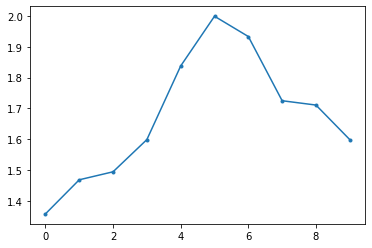

In [199]:
def get_velocity(gen):
    
    vel = []
    for i in range(1, len(gen)):
        d = gen[i]-gen[i-1]
        v = np.sqrt(np.sum(d**2, axis=1))
        vel.append(v)
    
    return np.array(vel)
    
crd = np.array([0.412400224561594, 0.19486213635121072, 0.6454603429351535, 0.06663592897203505])
crd = crd.reshape((1, int(len(crd)/2), 2))
crd = oversample(crd, pts=10)

gen = generate(network, crd, stdval, meanval)
vel = get_velocity(gen)

vel = ((vel-np.min(vel))/np.max(vel)+1)

#crd2 = []
#for i in range(len(crd[0])-1):
#    
#    tmp = oversample(np.array([crd[0, i:i+2]]), pts=int(np.mean(vel, axis=1)[i]))
#    
#    if len(crd2) == 0:
#        crd2 = tmp.copy()
#    else:
#        crd2 = np.concatenate((crd2, tmp), axis=1)
#
#
#gen2 = generate(network, np.array(crd2), stdval, meanval)
#vel2 = get_velocity(gen2)

plt.plot(np.max(vel, axis=1), marker=".")
#plt.plot(np.mean(vel2, axis=1), marker=".")